## PREPROCESAMIENTO

In [99]:
# === Montaje de Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Ruta base en Drive (ajústala si es necesario) ===
BASE_DIR = "/content/drive/MyDrive/Facultad/Ciencia de datos/dengue_ckan/AirFlow/include/outputs/"

# === Librerías ===
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pandas.api.types import is_numeric_dtype
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_validate
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from scipy.stats import loguniform, randint, uniform

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import joblib
import sklearn, numpy, pandas


import sys, platform
import numpy as np, sklearn, joblib



file_path = os.path.join(BASE_DIR, 'dengue_enriched_final.xlsx') # O .xlsx, etc.
df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# =========================
# PREPROCESAMIENTO DENGUE
# =========================


# 1) Resetear a defaults razonables
sns.reset_defaults()                 # resetea seaborn
mpl.rcParams.update(mpl.rcParamsDefault)  # resetea matplotlib

# -------- utilidades --------
def normalize_text(s: str):
    if pd.isna(s): return s
    s = str(s).strip()
    s = (s
         .replace("Ã‘", "Ñ")
         .replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u")
         .replace("Á","A").replace("É","E").replace("Í","I").replace("Ó","O").replace("Ú","U")
         )
    s = re.sub(r'\s+', ' ', s)
    return s.upper()

def coerce_numeric(x, allow_comma_decimal=True):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if allow_comma_decimal and (',' in s) and ('.' not in s):
        s = s.replace('.', '')       # separador de miles
        s = s.replace(',', '.')      # coma decimal -> punto
    # quitar posibles miles residuales 1.234 -> 1234 si aplica
    s = re.sub(r'(?<=\d)\.(?=\d{3}\b)', '', s)
    try:
        return float(s)
    except:
        return np.nan

def fix_prov_name(p):
    p = normalize_text(p)
    if p in {"CABA","CIUDAD AUTONOMA BUENOS AIRES","CAPITAL FEDERAL"}:
        return "CIUDAD AUTONOMA DE BUENOS AIRES"
    return p

def standardize_departamento(dep, prov=None):
    dep = normalize_text(dep) if pd.notna(dep) else dep
    prov = fix_prov_name(prov) if pd.notna(prov) else prov
    if prov == "CIUDAD AUTONOMA DE BUENOS AIRES" and isinstance(dep, str):
        m = re.search(r'COMUNA\s*(\d+)', dep)
        if m:
            return f"COMUNA {int(m.group(1))}"
    return dep

# -------- 1) Normalización básica de texto y tipos --------
display(df.head())
if "provincia_nombre" in df.columns:
    df["provincia_nombre"] = df["provincia_nombre"].apply(fix_prov_name)
if "departamento_nombre" in df.columns:
    df["departamento_nombre"] = df.apply(
        lambda r: standardize_departamento(r.get("departamento_nombre"), r.get("provincia_nombre")), axis=1
    )

# Fuerzo numéricos en potenciales columnas climáticas/geo-demográficas
maybe_numeric = [c for c in df.columns if any(k in c.lower() for k in ["lat","lon","temp","hum","prec","poblacion","densidad","superficie"])]
for c in maybe_numeric:
    if c in df.columns and df[c].dtype == "O":
        df[c] = df[c].apply(coerce_numeric)

# # -------- 3) Columna de casos (asegurar existencia y tipo) --------
candidate_case_cols = ["cantidad_casos","casos","n_casos","count_casos"]
case_col = next((c for c in candidate_case_cols if c in df.columns), None)
if case_col is None:
    raise ValueError("No se detectó columna de casos (esperaba una de: cantidad_casos/casos/n_casos/count_casos).")
if df[case_col].dtype == "O":
    df[case_col] = pd.to_numeric(df[case_col].apply(coerce_numeric), errors="coerce")
df[case_col] = df[case_col].fillna(0).clip(lower=0)

# -------- 4) Estandarización robusta de grupo_edad_desc + ID (sin nulos) --------
import re

# Bandas canónicas
_BANDS = [
    (0, 0,  "0 a 0"),
    (1, 4,  "1 a 4"),
    (5, 9,  "5 a 9"),
    (10,14, "10 a 14"),
    (15,19, "15 a 19"),
    (20,24, "20 a 24"),
    (25,34, "25 a 34"),
    (35,44, "35 a 44"),
    (45,64, "45 a 64"),
    (65,200,"65+"),
]

def _age_to_band_inclusive(min_age: int, max_age: int) -> str | None:
    """Devuelve la banda que contiene [min,max]; si cruza, None."""
    if max_age >= 65:
        return "65+"
    for a, b, label in _BANDS:
        if a <= min_age and max_age <= b:
            return label
    return None

def _age_single_band(age: int) -> str:
    """Banda que contiene una edad puntual."""
    if age >= 65:
        return "65+"
    for a, b, label in _BANDS:
        if a <= age <= b:
            return label
    return "DESCONOCIDO"

def _normalize_text_edades(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    s = (s.replace("á","a").replace("é","e").replace("í","i")
           .replace("ó","o").replace("ú","u").replace("ñ","n"))
    s = re.sub(r"\s+", " ", s)
    return s

def standardize_grupo_edad(desc) -> str:
    """
    Siempre devuelve una etiqueta canónica: '0 a 0', '1 a 4', ..., '65+' o 'DESCONOCIDO'.
    Política cuando cruza bandas: usar la BANDA DEL MÁXIMO (conservadora).
    """
    s = _normalize_text_edades(desc)
    if s is None or s in {"", "sin especificar", "sin esp"}:
        return "DESCONOCIDO"

    # Número puro -> banda
    if re.fullmatch(r"\d{1,3}", s):
        return _age_single_band(int(s))

    # Casos especiales
    if "neonato" in s or "posneonato" in s or ("menor" in s and "1" in s):
        return "0 a 0"
    if "igual a 1" in s:
        return "1 a 4"  # unificamos a la banda canónica

    # Rangos "de X a Y" / "X a Y" / "X hasta Y"
    m = re.search(r"(\d+)\s*(?:de\s+)?(?:a|hasta)\s*(\d+)", s)
    if m:
        x, y = int(m.group(1)), int(m.group(2))
        lo, hi = (x, y) if x <= y else (y, x)
        lab = _age_to_band_inclusive(lo, hi)
        if lab:
            return lab
        # Cruza bandas -> usar banda del máximo (conservadora)
        return _age_single_band(hi)

    # 65+ variantes
    if ("mayor" in s and "65" in s) or "65 y mas" in s or "65+" in s:
        return "65+"

    # Varios números sueltos (p.ej., "1 2 3 4 5 7")
    nums = [int(n) for n in re.findall(r"\d+", s)]
    if len(nums) >= 1:
        # Política: usar banda del máximo
        return _age_single_band(max(nums))

    return "DESCONOCIDO"

# Aplicar al DF
if "grupo_edad_desc" in df.columns:
    df["grupo_edad_desc_std"] = df["grupo_edad_desc"].apply(standardize_grupo_edad)
else:
    df["grupo_edad_desc_std"] = "DESCONOCIDO"

# Mapeo a ID (incluye DESCONOCIDO=99 para evitar nulos)
ID_MAP = {
    "0 a 0": 0,
    "1 a 4": 1,
    "5 a 9": 2,
    "10 a 14": 3,
    "15 a 19": 4,
    "20 a 24": 5,
    "25 a 34": 6,
    "35 a 44": 7,
    "45 a 64": 8,
    "65+": 9,
    "DESCONOCIDO": 99
}
df["grupo_edad_id"] = df["grupo_edad_desc_std"].map(ID_MAP).astype("Int64")


# -------- 5) Completar IDs de provincia y departamento --------
def completar_id_por_modo(df, nombre_col, id_col, adicionales_keys=None):
    if nombre_col not in df.columns or id_col not in df.columns:
        return df
    d = df.copy()
    # Mapa nombre -> id más frecuente observado
    mapa = (d[[nombre_col, id_col]]
            .dropna()
            .groupby(nombre_col)[id_col]
            .agg(lambda s: s.value_counts().idxmax())
            .to_dict())
    # Completar faltantes
    mask = d[id_col].isna() & d[nombre_col].notna()
    d.loc[mask, id_col] = d.loc[mask, nombre_col].map(mapa)

    # (opcional) completar con códigos deterministas si aún faltan
    if d[id_col].isna().any():
        # CABA: reglas típicas
        if nombre_col == "provincia_nombre":
            d.loc[d[id_col].isna() & (d[nombre_col] == "CIUDAD AUTONOMA DE BUENOS AIRES"), id_col] = 2
        if nombre_col == "departamento_nombre":
            if "provincia_nombre" in d.columns:
                m = d.loc[d[id_col].isna() & (d["provincia_nombre"]=="CIUDAD AUTONOMA DE BUENOS AIRES"), nombre_col].str.extract(r'COMUNA\s*(\d+)')
                idxs = m.dropna().index
                d.loc[idxs, id_col] = 2000 + m.loc[idxs, 0].astype(int)

        # Para el resto, generar IDs deterministas por hash corto
        still = d[id_col].isna() & d[nombre_col].notna()
        if still.any():
            base = d.loc[still, nombre_col].astype(str)
            if adicionales_keys and all(k in d.columns for k in adicionales_keys):
                extra = d.loc[still, adicionales_keys].astype(str).agg("|".join, axis=1)
                key = (base + "|" + extra)
            else:
                key = base
            d.loc[still, id_col] = key.map(lambda s: abs(hash(s)) % 10_000_000 + 1_000_000)
            d[id_col] = pd.to_numeric(d[id_col], errors="coerce").astype("Int64")
    return d

# Provincia
if "provincia_nombre" in df.columns and "provincia_id" in df.columns:
    df = completar_id_por_modo(df, "provincia_nombre", "provincia_id")
elif "provincia_nombre" in df.columns:
    df["provincia_id"] = pd.Series([pd.NA]*len(df), dtype="Int64")
    df = completar_id_por_modo(df, "provincia_nombre", "provincia_id")

# Departamento (usa provincia como llave adicional)
if "departamento_nombre" in df.columns and "departamento_id" in df.columns:
    df = completar_id_por_modo(df, "departamento_nombre", "departamento_id", adicionales_keys=["provincia_nombre"])
elif "departamento_nombre" in df.columns:
    df["departamento_id"] = pd.Series([pd.NA]*len(df), dtype="Int64")
    df = completar_id_por_modo(df, "departamento_nombre", "departamento_id", adicionales_keys=["provincia_nombre"])

# -------- 6) Fecha semanal (si aún no existe) --------
from datetime import date
def iso_week_start_safe(year, week):
    try: return pd.to_datetime(date.fromisocalendar(int(year), int(week), 1))
    except: return pd.NaT

if "fecha_semana" not in df.columns:
    if {"anio","semana_epidemiologica"}.issubset(df.columns):
        df["fecha_semana"] = df.apply(lambda r: iso_week_start_safe(r["anio"], r["semana_epidemiologica"]), axis=1)
    elif "fecha" in df.columns:
        df["fecha_semana"] = pd.to_datetime(df["fecha"], errors="coerce")
    else:
        df["fecha_semana"] = pd.NaT
df = df[df["fecha_semana"].notna()].copy()

# -------- 7) Promedio semanal de clima (precipitación, temperatura, humedad) --------
climate_cols = [c for c in df.columns if any(k in c.lower() for k in ["temp","hum","prec"]) and is_numeric_dtype(df[c])]
if not climate_cols:
    print("⚠️ No se detectaron columnas climáticas numéricas.")
else:
    dias = ["_L","_M","_X","_J","_V","_S","_D"]
    def promedio_intrafila(df, base):
        cols = [c for c in df.columns if c.lower().startswith(base) and any(c.endswith(d) for d in dias)]
        if cols:
            return df[cols].mean(axis=1)
        return None

    for base in ["temp", "hum", "prec"]:
        col_prom = f"{base}_sem_prom"
        val = promedio_intrafila(df, base)
        if isinstance(val, pd.Series):
            df[col_prom] = val

    for base in ["temp","hum","prec"]:
        if f"{base}_sem_prom" not in df.columns:
            cand = [c for c in climate_cols if c.lower().startswith(base)]
            if cand:
                df[f"{base}_row"] = df[cand].mean(axis=1)

    group_keys = [k for k in ["fecha_semana","provincia_nombre","departamento_nombre"] if k in df.columns]
    if not group_keys:
        group_keys = ["fecha_semana"]

    agg_dict = {case_col: "sum"}
    for base in ["temp","hum","prec"]:
        if f"{base}_sem_prom" in df.columns:
            agg_dict[f"{base}_sem_prom"] = "mean"
        if f"{base}_row" in df.columns:
            agg_dict[f"{base}_row"] = "mean"

    clima_sem = df.groupby(group_keys).agg(agg_dict).reset_index()

    clima_sem = clima_sem.rename(columns={
        "temp_sem_prom": "temp_semana",
        "hum_sem_prom": "hum_semana",
        "prec_sem_prom": "prec_semana",
        "temp_row": "temp_semana",
        "hum_row": "hum_semana",
        "prec_row": "prec_semana",
    })

    clima_cols_finales = [c for c in ["temp_semana","hum_semana","prec_semana"] if c in clima_sem.columns]
    if clima_cols_finales:
        clima_sem = (clima_sem
                     .groupby(group_keys, as_index=False)
                     .agg({case_col:"sum", **{c:"mean" for c in clima_cols_finales}}))

    print("clima_sem (muestra):")
    display(clima_sem.head())


# -------- 7.1) Columnas mes/año desde 'fecha' y filtro enero–junio --------
# Asegurar que 'fecha' exista y sea datetime
if "fecha" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
elif "fecha_semana" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha_semana"], errors="coerce")
else:
    raise ValueError("No se encontró 'fecha' ni 'fecha_semana' para derivar mes/año.")

# Crear columnas nuevas desde 'fecha'
df["mes"] = df["fecha"].dt.month.astype("Int64")
df["anio_fecha"] = df["fecha"].dt.year.astype("Int64")

# Filtrar meses de enero (1) a junio (6) inclusive
df = df[df["mes"].between(1, 6)].copy()

# (opcional) si también querés filtrar la tabla agregada 'clima_sem' cuando la generes,
# asegurate de que 'clima_sem' tenga una columna de fecha (o derivala igual que arriba)
# y aplicá el mismo filtro. Por ejemplo, si usás 'fecha_semana' en clima_sem:
# if "clima_sem" in locals():
#     if "fecha_semana" in clima_sem.columns:
#         clima_sem["mes"] = pd.to_datetime(clima_sem["fecha_semana"]).dt.month
#         clima_sem = clima_sem[clima_sem["mes"].between(1,6)].copy()


# -------- 9) Reporte final de nulos --------
print("\n--- VERIFICACIÓN DE NULOS (post-procesamiento) ---")
display(df.isna().sum().sort_values(ascending=False).to_frame("n_nulos"))
print("Filas x Columnas:", df.shape)


# --- Diagnóstico: revisar cuántos quedaron como DESCONOCIDO ---
n_total = len(df)
n_descon = (df["grupo_edad_desc_std"] == "DESCONOCIDO").sum()
porc = (n_descon / n_total * 100) if n_total > 0 else 0

print(f"Registros con grupo_edad_desc_std = 'DESCONOCIDO': {n_descon:,} de {n_total:,} ({porc:.2f}%)")

# Ver ejemplos de los valores originales que generaron 'DESCONOCIDO'
display(
    df.loc[df["grupo_edad_desc_std"] == "DESCONOCIDO", ["grupo_edad_desc"]]
      .value_counts()
      .reset_index(name="frecuencia")
      .head(20)
)

df_nulos = df[df["grupo_edad_desc_std"].isna()]
display(df_nulos)


,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semana_epidemiologica,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,...,prec_L,prec_M,prec_X,prec_J,prec_V,prec_S,prec_D,superficie,poblacion,densidad
0,2001,COMUNA 5,2,CABA,2019,3,Dengue,6.0,De 15 a 19 anos,1,...,2.9,11.9,0.0,0.4,1.5,1.0,0.0,6.7,194271.0,28995.7
1,2001,COMUNA 1,2,CABA,2019,7,Dengue,6.0,De 15 a 19 anos,1,...,18.3,0.0,0.1,7.7,0.0,0.0,0.0,17.9,223554.0,12489.1
2,2001,COMUNA 1,2,CABA,2019,7,Dengue,8.0,De 25 a 34 anos,1,...,18.3,0.0,0.1,7.7,0.0,0.0,0.0,17.9,223554.0,12489.1
3,2001,COMUNA 14,2,CABA,2019,8,Dengue,10.0,De 45 a 65 anos,1,...,0.0,0.0,0.1,0.0,2.1,22.8,0.0,15.9,248635.0,15637.4
4,2010,COMUNA 10,2,CABA,2019,9,Dengue,9.0,De 35 a 44 anos,1,...,0.0,0.0,0.5,0.0,0.3,0.9,0.0,12.6,173004.0,13730.5


clima_sem (muestra):


,fecha_semana,provincia_nombre,departamento_nombre,cantidad_casos,temp_semana,hum_semana,prec_semana
0,2018-01-01,FORMOSA,FORMOSA,3,26.385714,66.000000,2.900000
1,2018-01-08,CHACO,O'HIGGINS,1,28.328571,60.857143,2.714286
2,2018-01-08,MISIONES,CAPITAL,1,25.871429,76.285714,6.757143
3,2018-01-15,FORMOSA,FORMOSA,1,26.028571,80.428571,11.628571
4,2018-01-22,CHACO,2 DE ABRIL,1,26.228571,82.142857,8.457143



--- VERIFICACIÓN DE NULOS (post-procesamiento) ---


,n_nulos
superficie,136
densidad,136
poblacion,136
provincia_id,0
departamento_id,0
departamento_nombre,0
evento_nombre,0
grupo_edad_id,0
grupo_edad_desc,0
cantidad_casos,0


Filas x Columnas: (65273, 46)
Registros con grupo_edad_desc_std = 'DESCONOCIDO': 71 de 65,273 (0.11%)


,grupo_edad_desc,frecuencia
0,Sin Especificar,52
1,-,17
2,Edad Sin Esp.,1
3,sin especificar,1


,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semana_epidemiologica,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,...,poblacion,densidad,grupo_edad_desc_std,fecha_semana,temp_sem_prom,hum_sem_prom,prec_sem_prom,fecha,mes,anio_fecha


Se agrega la region

DIVIDIR DATASET TEST Y TRAIN filtrando por la region TEMPLADO

In [101]:
display(df.head())

,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semana_epidemiologica,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,...,poblacion,densidad,grupo_edad_desc_std,fecha_semana,temp_sem_prom,hum_sem_prom,prec_sem_prom,fecha,mes,anio_fecha
0,2001,COMUNA 5,2,CIUDAD AUTONOMA DE BUENOS AIRES,2019,3,Dengue,4,De 15 a 19 anos,1,...,194271.0,28995.7,15 a 19,2019-01-14,20.914286,76.428571,2.528571,2019-01-14,1,2019
1,2001,COMUNA 1,2,CIUDAD AUTONOMA DE BUENOS AIRES,2019,7,Dengue,4,De 15 a 19 anos,1,...,223554.0,12489.1,15 a 19,2019-02-11,20.685714,69.714286,3.728571,2019-02-11,2,2019
2,2001,COMUNA 1,2,CIUDAD AUTONOMA DE BUENOS AIRES,2019,7,Dengue,6,De 25 a 34 anos,1,...,223554.0,12489.1,25 a 34,2019-02-11,20.685714,69.714286,3.728571,2019-02-11,2,2019
3,2001,COMUNA 14,2,CIUDAD AUTONOMA DE BUENOS AIRES,2019,8,Dengue,9,De 45 a 65 anos,1,...,248635.0,15637.4,65+,2019-02-18,26.285714,71.428571,3.571429,2019-02-18,2,2019
4,2010,COMUNA 10,2,CIUDAD AUTONOMA DE BUENOS AIRES,2019,9,Dengue,7,De 35 a 44 anos,1,...,173004.0,13730.5,35 a 44,2019-02-25,18.871429,62.428571,0.242857,2019-02-25,2,2019


se filtran meses


In [102]:
# ===== Filtro de meses: ENE–JUN =====
_base = df.copy()




# Asegurar columna 'fecha_semana' y 'mes'
if "fecha_semana" not in _base.columns:
    raise ValueError("Falta 'fecha_semana' para filtrar por meses.")

_base["fecha_semana"] = pd.to_datetime(_base["fecha_semana"], errors="coerce")
if "mes" not in _base.columns:
    _base["mes"] = _base["fecha_semana"].dt.month.astype("Int64")

# Filtrar meses 1..6 (enero–junio)
# _base = _base[_base["mes"].between(1, 6)].copy()

# Usar este dataset filtrado en la Sección 1
df_Meses = _base.copy()


In [103]:
# (El código anterior de groupby se mantiene igual)

df = df.groupby(
    [
        "provincia_nombre", "departamento_nombre", "anio",
        "semana_epidemiologica", "fecha_semana",
        "temp_sem_prom", "hum_sem_prom", "prec_sem_prom",
        "densidad", "grupo_edad_desc_std"
    ]
)["cantidad_casos"].sum().reset_index()

# ========================================================
# AGREGAR LAGS ANTES DE DEFINIR LA VARIABLE OBJETIVO
# ========================================================

# Ordenamos por provincia/departamento/fecha
df = df.sort_values(["provincia_nombre", "departamento_nombre", "fecha_semana"])

# Creamos lags de 1, 2 y 4 semanas
df["lag1"] = df.groupby(["provincia_nombre", "departamento_nombre"])["cantidad_casos"].shift(1)
df["lag2"] = df.groupby(["provincia_nombre", "departamento_nombre"])["cantidad_casos"].shift(2)
df["lag4"] = df.groupby(["provincia_nombre", "departamento_nombre"])["cantidad_casos"].shift(4)

# Llenamos los NaN iniciales con 0 (o podríamos dejarlos)
df[["lag1", "lag2", "lag4"]] = df[["lag1", "lag2", "lag4"]].fillna(0)

print("Lags agregados:")
display(df[["cantidad_casos", "lag1", "lag2", "lag4"]].head(15))

# ============================================
# SECCIÓN: FEATURES ESTACIONALES (mes/semana)
# ============================================

# Aseguramos que fecha_semana es datetime
df["fecha_semana"] = pd.to_datetime(df["fecha_semana"], errors="coerce")

# Mes calendario
df["mes"] = df["fecha_semana"].dt.month

# Semana del año (1–52)
df["semana"] = df["fecha_semana"].dt.isocalendar().week.astype(int)

# Codificación cíclica de mes (12 meses)
df["mes_sin"] = np.sin(2 * np.pi * df["mes"] / 12)
df["mes_cos"] = np.cos(2 * np.pi * df["mes"] / 12)

# Codificación cíclica de semana (52 semanas aprox)
df["sem_sin"] = np.sin(2 * np.pi * df["semana"] / 52)
df["sem_cos"] = np.cos(2 * np.pi * df["semana"] / 52)

# Si querés usar SOLO las versiones cíclicas, podés droppear los enteros:
# df = df.drop(columns=["mes", "semana"])



# # === 2. Definir la variable objetivo (clases 0-9) ===

# df["mes"] = df["fecha_semana"].dt.month

# df_season = df[df["mes"].isin([1,2,3,4,5,6])].copy()

# print("Filas antes:", len(df))
# print("Filas después de filtrar temporada:", len(df_season))

df = df_season  # usamos este desde acá en adelante

# NUEVA escala de 3 clases: 0, 1, 2

target_col = "cantidad_casos"
df[target_col] = df[target_col].fillna(0)

bins = [-np.inf, 49, 199, np.inf]
labels = [0, 1, 2]

df["clase_casos"] = pd.cut(df[target_col], bins=bins, labels=labels).astype(int)

tabla_clases = pd.DataFrame({
    "clase": labels,
    "bin_left": bins[:-1],
    "bin_right": bins[1:]
})

import numpy as np
def safe_edge(x):
    if np.isneginf(x): return "0"
    if np.isposinf(x): return "200+"
    return str(int(x))

tabla_clases["rango"] = tabla_clases.apply(
    lambda r: f"{safe_edge(r['bin_left'])} a {safe_edge(r['bin_right'])}",
    axis=1
)

print("Escala de clases usada:")
display(tabla_clases)
print("\nDistribución de clases:")
display(df["clase_casos"].value_counts(normalize=True).sort_index().to_frame("%"))



Lags agregados:


,cantidad_casos,lag1,lag2,lag4
0,1,0.0,0.0,0.0
1,1,1.0,0.0,0.0
2,1,1.0,1.0,0.0
3,1,1.0,1.0,0.0
4,1,1.0,1.0,1.0
5,1,1.0,1.0,1.0
6,2,1.0,1.0,1.0
7,1,2.0,1.0,1.0
8,1,1.0,2.0,1.0
9,1,1.0,1.0,1.0


Escala de clases usada:


,clase,bin_left,bin_right,rango
0,0,-inf,49.0,0 a 49
1,1,49.0,199.0,49 a 199
2,2,199.0,inf,199 a 200+



Distribución de clases:


,%
clase_casos,
0,0.935951
1,0.053140
2,0.010910


In [104]:
# === 3. Selección de features y split ===

from sklearn.model_selection import train_test_split

# ============================
# SELECCIÓN DE FEATURES
# ============================

# Columnas que NO queremos como features
cols_drop = [
    "provincia_nombre",
    "departamento_nombre",
    "grupo_edad_desc_std",
    "fecha_semana",          # se usa solo para ordenar, no como feature
    "semana_epidemiologica",
    "clase_casos",
    "cantidad_casos",
]

# 1) Definimos las columnas numéricas que vamos a usar
X_tmp = df.drop(columns=cols_drop, errors="ignore")

# Nos quedamos SOLO con numéricas
X_tmp = X_tmp.select_dtypes(include=["int64", "float64"])

feature_cols = X_tmp.columns.tolist()

print("Variables numéricas que se usarán como features:")
display(pd.DataFrame({"col": feature_cols}))

# ============================
# ARMADO DE X, y Y SPLIT
# ============================

# Usamos la columna fecha_semana SOLO para hacer el split temporal
if "fecha_semana" in df.columns:
    df_sorted = df.sort_values("fecha_semana").reset_index(drop=True)
    X = df_sorted[feature_cols].copy()
    y = df_sorted["clase_casos"].copy()

    # 80% primeros registros para train, 20% últimos para test
    split_idx = int(0.8 * len(df_sorted))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

else:
    # Si no hubiera fecha, usamos split aleatorio estratificado
    X = df[feature_cols].copy()
    y = df["clase_casos"].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Variables numéricas que se usarán como features:


,col
0,anio
1,temp_sem_prom
2,hum_sem_prom
3,prec_sem_prom
4,densidad
5,lag1
6,lag2
7,lag4


Shapes:
X_train: (42604, 8) X_test: (10652, 8)
y_train: (42604,) y_test: (10652,)


In [105]:
# === 4. Preprocesamiento ===

# Detectar columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
#cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

# Pipeline para numéricas: imputar + escalar
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para categóricas: imputar + OneHot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


Columnas numéricas: ['anio', 'temp_sem_prom', 'hum_sem_prom', 'prec_sem_prom', 'densidad', 'lag1', 'lag2', 'lag4']
Columnas categóricas: []


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Mejores hiperparámetros encontrados:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}
Mejor F1-macro en CV: 0.6910313564364851

Accuracy en TEST: 0.945
F1-macro en TEST: 0.635

=== Classification report (por clase) ===
              precision    recall  f1-score   support

           0      0.995     0.954     0.974     10243
           1      0.353     0.735     0.477       344
           2      0.360     0.615     0.455        65

    accuracy                          0.945     10652
   macro avg      0.570     0.768     0.635     10652
weighted avg      0.970     0.945     0.955     10652



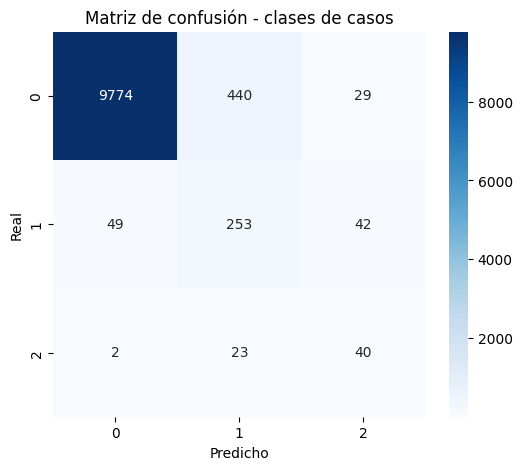

In [106]:
# === 5. Modelo base: Random Forest Clasificador ===

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# # y_train ya definido después del split
# classes = np.unique(y_train)
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=classes,
#     y=y_train
# )
# weights_dict = {cls: w for cls, w in zip(classes, class_weights)}
# print("Pesos de clase:", weights_dict)

# # Vector de pesos por fila
# sample_weight = y_train.map(weights_dict).to_numpy()

# from xgboost import XGBClassifier

# model = XGBClassifier(
#     n_estimators=400,
#     max_depth=6,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective="multi:softprob",
#     eval_metric="mlogloss",
#     random_state=42
# )

# model.fit(X_train, y_train, sample_weight=sample_weight)
# y_pred = model.predict(X_test)



# ============================================
# SECCIÓN: TUNING FINO DE XGBClassifier
# ============================================

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Modelo base (no importa mucho porque lo vamos a tunear)
xgb_base = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    tree_method="hist"  # si estás en GPU/CPU moderna va rápido
)

# Espacio de búsqueda (podés ajustarlo si querés)
param_distributions = {
    "n_estimators":    [200, 300, 400, 600],
    "max_depth":       [3, 4, 5, 6, 8],
    "learning_rate":   [0.01, 0.03, 0.05, 0.1],
    "subsample":       [0.6, 0.8, 1.0],
    "colsample_bytree":[0.6, 0.8, 1.0],
    "min_child_weight":[1, 3, 5],
    "gamma":           [0.0, 0.1, 0.3]
}

# CV temporal para respetar la serie
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=25,                 # cantidad de combinaciones a probar
    scoring="f1_macro",        # optimizamos el equilibrio entre clases
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    refit=True,                # el mejor modelo queda en random_search.best_estimator_
    random_state=42
)

# Entrenamos el tuning pasando los sample_weight
random_search.fit(X_train, y_train, sample_weight=sample_weight)

print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)
print("Mejor F1-macro en CV:", random_search.best_score_)

# Mejor modelo ya entrenado
best_model = random_search.best_estimator_

# Evaluamos en TEST
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
print(f"\nAccuracy en TEST: {acc:.3f}")
print(f"F1-macro en TEST: {f1m:.3f}")

print("\n=== Classification report (por clase) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión - clases de casos")
plt.show()


# clf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=None,
#     min_samples_leaf=2,
#     random_state=42,
#     n_jobs=-1,
#     class_weight="balanced"  # por si hay clases desbalanceadas
# )

# model = Pipeline(steps=[
#     ("preprocess", preprocessor),
#     ("clf", clf)
# ])


#Descargar para stremlit

In [115]:
#print("Versions -> sklearn:", sklearn.__version__, "numpy:", numpy.__version__, "pandas:", pandas.__version__)

# Suponiendo que tu objeto final se llama `pipeline`
joblib.dump(best_model, "model.pkl")

['model.pkl']